# Replicating Deep Learning NLP Papers in Keras; A GPU Tutorial for Deep Learning Beginners
<br>
<img src="https://orig00.deviantart.net/05db/f/2014/124/d/e/mascara_contra_gas___gas_mask_by_caritnarib-d7h5hvb.png" style="width: 200px;"/>
<br>
<br>
<br>
A comprehensive and in-depth tutorial on NLP (classifying toxic comments), Deep Learning, and Keras. Using:
- Keras
- Text Classification Improved by Integrating Bidirectional LSTM with Two-dimensional Max Pooling (Peng Zhou, et al. 2016) https://arxiv.org/pdf/1611.06639.pdf
- Toxic Comment Classification Challenge (Kaggle Competition)
- A little humor

In [1]:
from IPython.display import Image # display images

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import seaborn as sns
sns.set()
from wordcloud import WordCloud ,STOPWORDS

from PIL import Image as PILImage



# Keras
from keras.layers import (Dense, Input, Bidirectional, Activation, Dropout, Embedding, Flatten, CuDNNLSTM, 
                          Conv2D, MaxPool2D, concatenate, K, Reshape, LSTM)
    
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.preprocessing import text, sequence
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

from keras.utils import multi_gpu_model



# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf # tensorflow

/home/ubuntu/src/anaconda3/envs/kc/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Table of Contents
1. [Competition Overview](#Competition-Overview)
    1. [Description](#Description)
    2. [Evaluation](#Evaluation)
    3. [Data-Overview](#Data-Overview)
2. [What is Keras?](#What-is-Keras)
    1. [Keras Overview](#Keras-Overview)
    2. [Why Keras Over (Raw)Tensorflow](#So,-Why-Keras-Over-Tensorflow?)
3. [Overview of The Paper](#Overview-of-The-Paper)
4. [Overview of Layers](#Overview-of-Layers)
    1. [Bidirectional Recurrent Layer](#Bidirectional-Recurrent-Layer)
    2. [2D Convolution Layer](#2D-Convolution-Layer)
    3. [2D Max Pooling Layer](#2D-Max-Pooling-Layer)
5. [The Model](#The-Model)
    1. [Example](#Example-Below:)
    2. [Embeddings](#Embeddings)
    3. [Model Hyperparameter Space](#Model-Hyperparameter-Space)
    4. [Hardware](#Hardware)
    5. [Building the GPU Model in Keras](#Building-the-GPU-Model-in-Keras)
    6. [Fitting and Evaluating the Model](#Fitting-and-Evaluating-the-Model)
    7. [Fit Model on Entire Dataset](#Fit-Model-on-Entire-Dataset)
    8. [Model Results](#Model-Results)
6. [CPU Comparison](#CPU-Comparison)
<br> 
<br>
<br>

## Competition Overview
Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. The Kaggle Toxic Comment Classification Challenge sponsored by the Conversation AI team sets out to discover and apply machine learning to identify toxic comments. This (potentially) will allow platforms to identify toxic comments and to successfully fascilitate discussions at scale.
<br>
<br>
<br>
### Description
The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).
<br>
<br>
In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.
<br>
<br>
***Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.***
<br>
<br>
<br>
### Evalution
Submissions are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.
<br>
<br>
<br>
### Data Overview
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

We must create a model which predicts a probability of each type of toxicity for each comment.
<br>
<br>

File descriptions:
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
<br>
<br>

***Source: Toxic Comment Classification Challenge, https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/***
<br>
<br>
<br>

#### ***Disclaimer Part 2: This may be considered profane, vulgar, or offensive***
<br>
<br>

In [2]:
# GLOBE PATHS
TRAIN_FILE = '../data/train.csv'
TEST_FILE = '../data/test.csv'
EMBEDDING_FILE = '../data/glove.42B.300d.txt'


# load
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)


# fill and store X's an y's
X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("fillna").values

#### TOXIC COMMENT

In [3]:
print(train[train.severe_toxic==1].iloc[3,1])

Hi 

Im a fucking bitch.

50.180.208.181


#### SEVERE TOXIC COMMENT

In [4]:
print(train[train.severe_toxic==1].iloc[4,1])

What a motherfucking piece of crap those fuckheads for blocking us!


#### THREAT COMMENT

In [5]:
print(train[train.threat==1].iloc[1,1])

I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


#### OBSCENE COMMENT 

In [6]:
print(train[train.obscene==1].iloc[1,1])

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


#### IDENTITY HATE

In [7]:
print(train[train.identity_hate==1].iloc[4,1])

u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


#### Target Frequency Breakdown

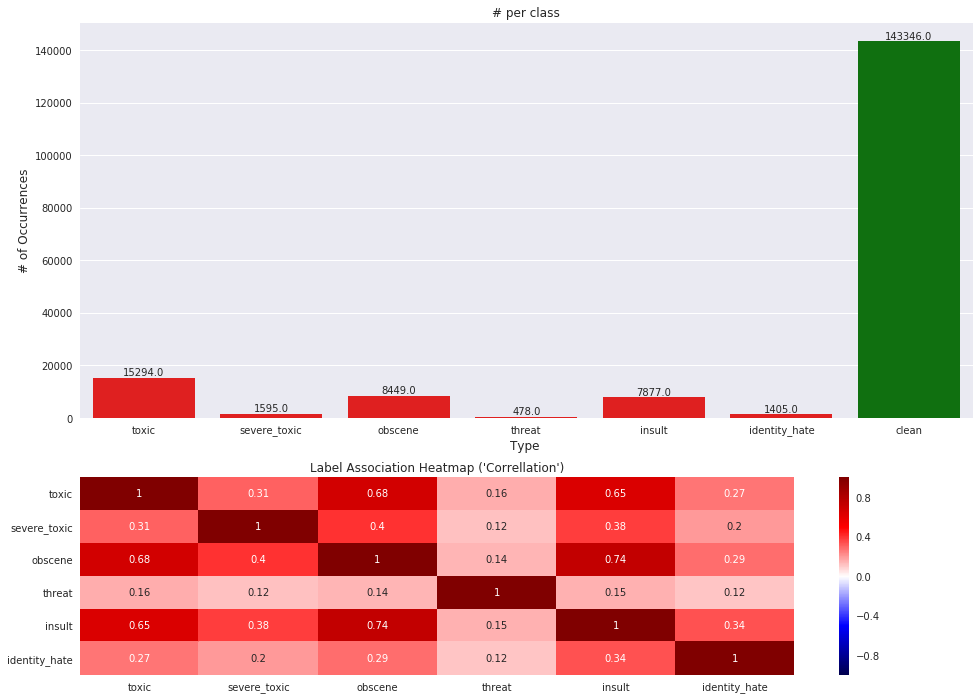

In [8]:
# tox label counts
tox_labels = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].copy()
rowsums = tox_labels.sum(axis=1)
train['clean']=(rowsums==0)
tox_labels['clean']=train['clean'].copy()
x = tox_labels.sum().copy()

# create a 1 X 2 grid
plt.figure(figsize=(16,12))
gs = grd.GridSpec(2, 1, height_ratios=[2 , 1], wspace=0.1)


# bar plot
ax = plt.subplot(gs[0])
sns.barplot(x.index, x.values, palette=['r','r','r','r','r','r','g'], ax = ax)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    

# corr matrix
corr = tox_labels[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].corr()

# heatmap
ax2 = plt.subplot(gs[1])
sns.heatmap(corr, cmap="seismic", ax = ax2,
            xticklabels=corr.columns.values, vmin = -1.0, vmax = 1.0,
            yticklabels=corr.columns.values, annot=True) 
plt.title("Label Association Heatmap ('Correllation')")
plt.show()

#### Vulgar (non-clean) Comment Word Cloud

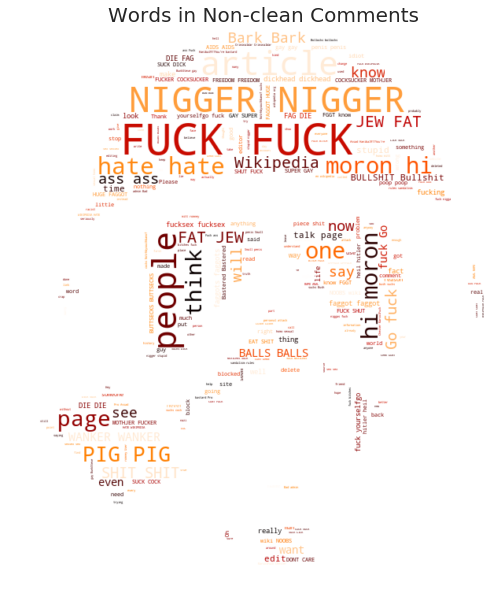

In [9]:
# stopwords
stopword=set(STOPWORDS)

# non-clean comments
clean_mask=np.array(PILImage.open("tutorial_assets/toxic.png"))

# wordcloud for non-clean comments
subset=train[train.clean!=True]
texts=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=500,mask=clean_mask,stopwords=stopword,margin=5)
wc.generate(" ".join(texts))

plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words in Non-clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_heat' , random_state=17), interpolation='bilinear');

#### Clean Comment Word Cloud

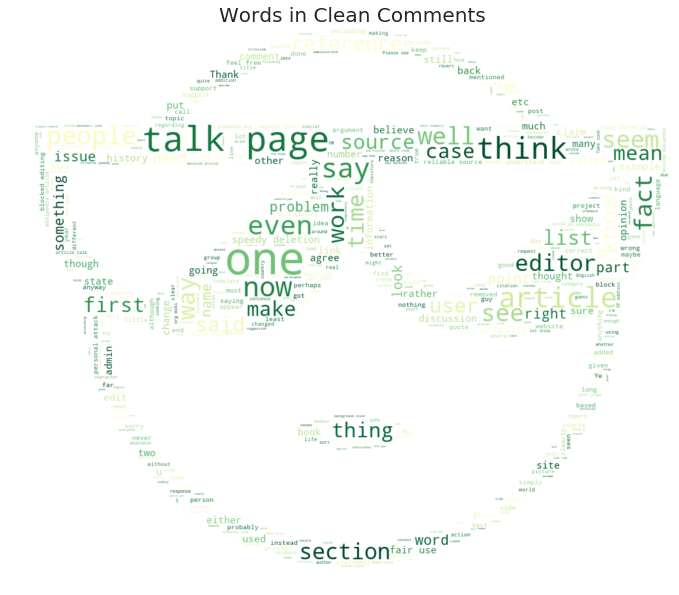

In [10]:
#clean comments
clean_mask=np.array(PILImage.open("tutorial_assets/face.png"))

#wordcloud for clean comments
subset=train[train.clean==True]
texts=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=500,mask=clean_mask,stopwords=stopword,margin=5)
wc.generate(" ".join(texts))

plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'YlGn' , random_state=17), interpolation='bilinear');

## What is Keras
<br>
### Keras Overview
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
<br>
<br>
Use Keras if you need a deep learning library that:
- Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
- Supports both convolutional networks and recurrent networks, as well as combinations of the two.
- Runs seamlessly on CPU and GPU.
<br>
<br>

***Source: Keras.io ***
<br>
<br>
<br>
*In this tutorial, we will be using the tensorflow backend for Keras. Currently, it is the only backend that supports a multi-GPU model seamlessly.*
<br>
<br>
<br>

### So, Why Keras Over (Raw)Tensorflow?
Simply put, in less than 100 lines of code an everyday data scientist can implement powerful deep learning architectures to solve problems of varying complexity... In all honesty, it's legos but, for grown-up programers.

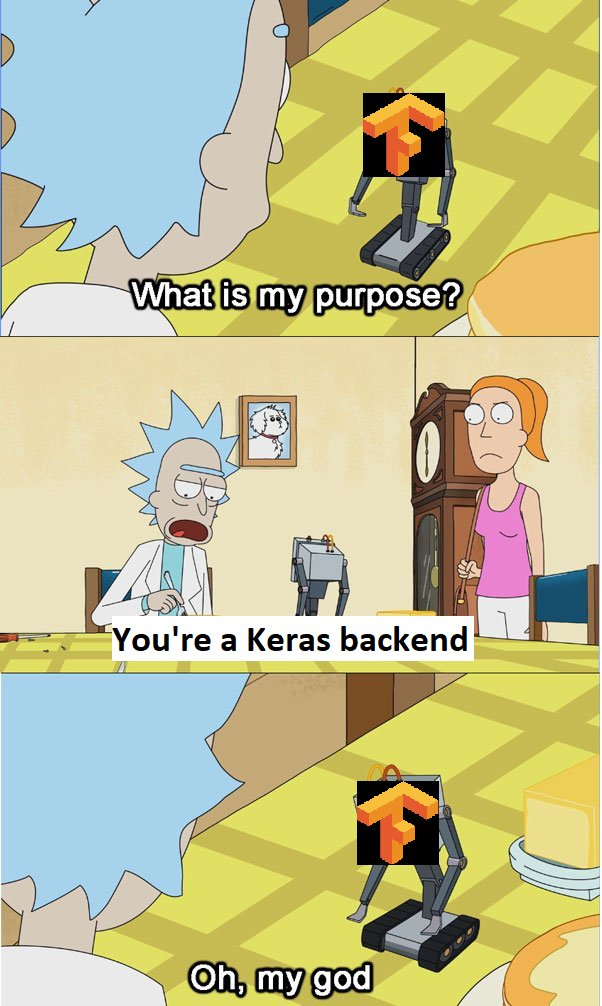

In [11]:
# Source: https://twitter.com/ai_memes
Image('tutorial_assets/tensorflow_meme.jpg')

## Overview of The Paper

Recurrent Neural Network (RNN) is one of the most popular architectures used in Natural Language Processsing (NLP) tasks because its recurrent structure is very suitable to process variablelength
text. RNN can utilize distributed representations of words by first converting the tokens comprising each text into vectors, which form a matrix. And this matrix includes two dimensions: the time-step dimension and the feature vector dimension. Then most existing models usually utilize one-dimensional (1D) max pooling operation or attention-based operation only on the time-step dimension to obtain a fixed-length vector. However, the features on the feature vector dimension are not mutually independent, and simply applying 1D pooling operation over the time-step dimension independently may destroy the structure of the feature representation. On the other hand, applying two-dimensional (2D) pooling operation over the two dimensions may sample more meaningful features for sequence modeling tasks. To integrate the features on both dimensions of the matrix, this paper explores applying 2D max pooling operation to obtain a fixed-length representation of the text. This paper also utilizes 2D convolution to sample more meaningful information of the matrix. Experiments are conducted on six text classification tasks, including sentiment analysis, question classification, subjectivity classification and newsgroup classification. Compared with the state-of-the-art models, the proposed models achieve excellent performance on 4 out of 6 tasks. Specifically, one of the proposed models achieves highest accuracy on Stanford Sentiment Treebank binary classification and fine-grained classification tasks.

<br>
<br>
***Source: Text Classification Improved by Integrating Bidirectional LSTM with Two-dimensional Max Pooling, https://arxiv.org/pdf/1611.06639.pdf***

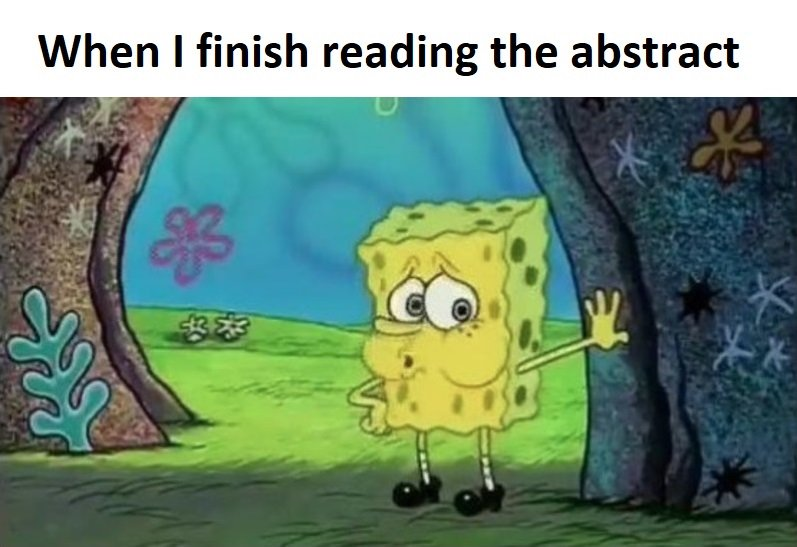

In [15]:
# Source: https://twitter.com/ai_memes
Image('tutorial_assets/abstract_meme.jpg')

## Overview of Layers
<br>
### Bidirectional Recurrent Layer

Bidirectional recurrent neural networks(RNN) are really just putting two independent RNNs together. The input sequence is fed in normal time order for one network, and in reverse time order for another. The outputs of the two networks are usually concatenated at each time step, though there are other options, e.g. summation.
<br>
<br>
This structure allows the networks to have both backward and forward information about the sequence at every time step.
<br>
<br>
***Source: CeShine Lee, https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66***

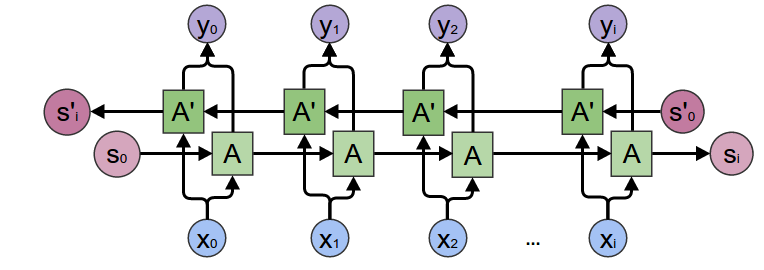

In [12]:
# Source: Colah, http://colah.github.io/posts/2015-09-NN-Types-FP/
Image('tutorial_assets/Bidirectional_RNN.png')

### 2D Convolution Layer

Convolution is an important operation in signal and image processing. Convolution operates on two signals (in 1D) or two images (in 2D): you can think of one as the “input” signal (or image), and the other (called the kernel) as a “filter” on the input image, producing an output image (so convolution takes two images as input and produces a third as output).
<br>
<br>
We can also apply convolution in 2D—our images and kernels are now 2D functions or matrices; we’ll stick with intensity/numeric "images" for now, and leave color for another time). For 2D convolution, just as before, we slide the kernel over each pixel/cell of the image/matrix, multiply the corresponding entries of the input image and kernel, and add them up—the result is the new value of the image.
<br>
<br>
***Source: http://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf***

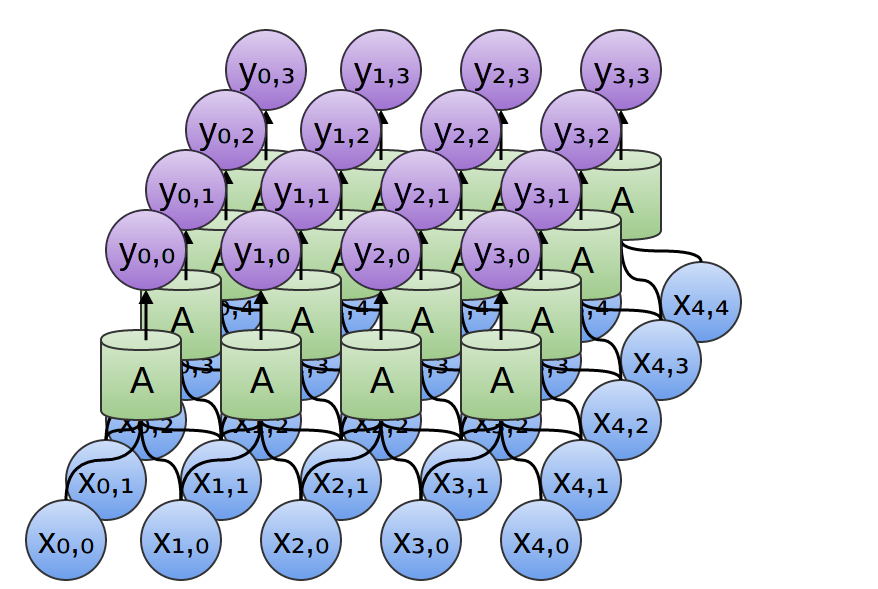

In [13]:
# Source: Colah, http://colah.github.io/posts/2015-09-NN-Types-FP/
Image('tutorial_assets/Conv2.png')

### 2D Max Pooling Layer

Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.
<br>
<br>
Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation.
<br>
<br>
***Source: Stanford's CS231n github***

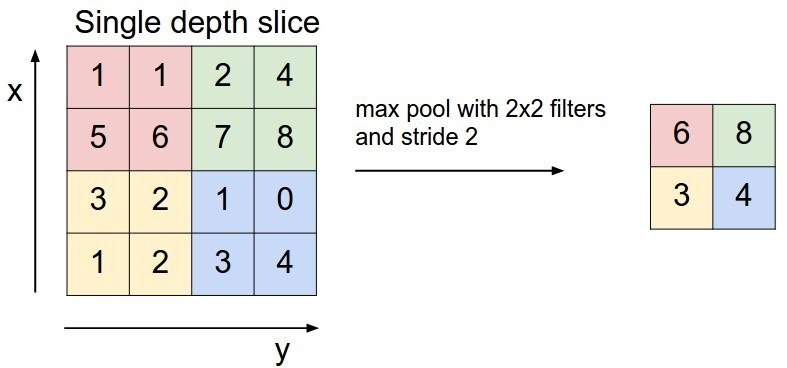

In [14]:
# Source: Stanford's CS231n github
Image('tutorial_assets/max_pooling_layer.jpg')

## The Model

The overall model consists of five parts:
1. Embedding Layer (GloVe - 300d)
2. BLSTM Layer (with summation merge)
3. Two-dimensional Convolution Layer 
4. Two dimensional max pooling Layer
5. Output Layer
<br>
<br>

### Example Below: 
A BLSTM-2DCNN for the 7 word input sentence. Word embeddings have size 3, and BLSTM has 5 hidden units. The height and width of convolution filters and max pooling operations are 2, 2 respectively.

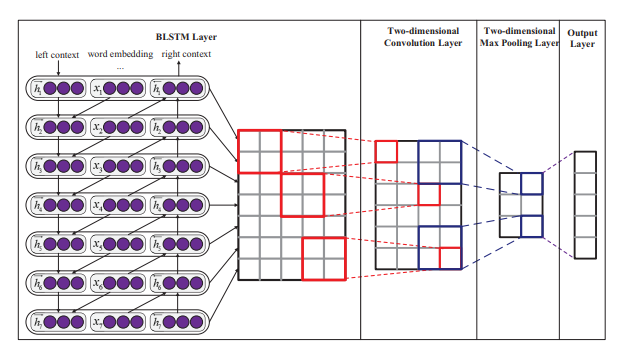

In [16]:
# Source: Text Classification Improved by Integrating Bidirectional LSTM with Two-dimensional Max Pooling, https://arxiv.org/pdf/1611.06639.pdf
Image('tutorial_assets/Model_Example.PNG', width=1000)

### Embeddings

The word embeddings are pre-trained on much larger unannotated corpora to achieve better generalization given limited amount of training data (Turian et al., 2010). In particular, our experiments utilize the GloVe embeddings trained by Pennington et al. (2014) on 6 billion tokens of Wikipedia 2014 and Gigaword 5. Words not present in the set of pre-trained words are initialized by zeros. The dimension of word embeddings is 300.

More info on GloVe Embeddings: https://nlp.stanford.edu/projects/glove/

In [17]:
# embedding info
max_features = 300000
maxlen = 200
embed_size = 300



# tokenize
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)



# get word vectors
embeddings_index = {}
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i >= max_features: continue
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 1917494 word vectors.


### Model Hyperparameter Space

- The dimension of word embeddings is 300 
- The hidden units of LSTM is 300. 
- We use 100 convolutional filters each for window sizes of (5,5) 
- 2D pooling size of (5,5) 
- We set the mini-batch size as 32 
- The learning rate of Adam as the default value. 
- For regularization, we employ: 
    - Dropout rate of 0.5 for the word embeddings 
    - 0.2 for the BLSTM layer 
    - 0.4 for the penultimate layer 
    - Used l2 penalty with coefficient 10^−5 over the parameters
<br>
<br>

### Hardware
This model was trained the amazon p3.8xlarge instance type and a deep learning AMI

#### p3.8xlarge

| Instance Size | GPUs - Tesla V100 | GPU Peer to Peer | GPU Memory (GB) | vCPUs | Memory (GB) | Network Bandwidth | EBS Bandwidth | On-Demand Price/hr* | 1-yr Reserved Instance Effective Hourly* | 3-yr Reserved Instance Effective Hourly* |
|---------------|-------------------|------------------|-----------------|-------|-------------|-------------------|---------------|---------------------|------------------------------------------|------------------------------------------|
| p3.8xlarge    | 4                 | NVLink           | 64              | 32    | 244         | 10 Gbps           |  7 Gbps        | 12.24 USD             | 7.96 USD                                  | 9.87 USD                               |

https://aws.amazon.com/ec2/instance-types/p3/
<br>
<br>

### Building the GPU Model for Multiple GPUs in Keras

If you are running on the TensorFlow or CNTK backends, your code will automatically run on GPU if any available GPU is detected. But what if we would like to run our model on multiple GPUs? 

Things you should know:
- Keras recommends using the TensorFlow backend. 
- There are two ways to run a single model on multiple GPUs: data parallelism and device parallelism.
- In most cases, what you need is most likely data parallelism.
- Consider using the CuDNN optimized layers in Keras for the best uptick in performance.
- *In this example we'll use a data parallel model.*
<br>
<br>

#### Code
With two lines of code we can convert our standard model to a multi-gpu model.
```python
from keras.utils import multi_gpu_model

# Replicates `model` on 4 GPUs.
model = Model(inputs = inp, outputs = x)
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

***Source: https://keras.io/getting-started/faq/#how-can-i-run-a-keras-model-on-multiple-gpus***

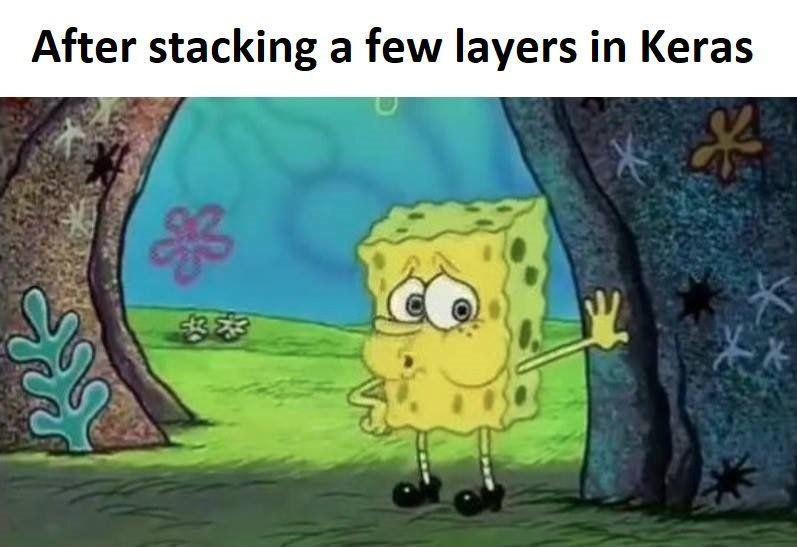

In [18]:
# average AUC callback
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['roc_val'] = score
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

            
            
# build model
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen)(inp)
    x = Dropout(0.5)(x)    

    x = Bidirectional(CuDNNLSTM(300, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(0.2)(x)
    x = Reshape((200, 300, 1))(x)

    x = Conv2D(100, kernel_size=(5,5), padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=(5,5))(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(6, activation = "sigmoid",  kernel_regularizer=regularizers.l2(.00001))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    parallel_model = multi_gpu_model(parallel_model, gpus=4)
    parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return parallel_model



# get model
model = get_model()



# Source: https://twitter.com/ai_memes
Image('tutorial_assets/keras_meme.jpg')

### Fitting and Evaluating the Model

We randomly select 10% of the training data as the development set. The evaluation metric is the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.

#### Notice the best epoch: 2

In [19]:
# fit parameters
batch_size = 32
epochs = 5

# get test/train and ROC AUC callback
[X_tra, X_val, y_tra, y_val] = train_test_split(x_train, y_train, test_size=.1, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

# fit
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 517s 4ms/step - loss: 0.0590 - acc: 0.9800 - val_loss: 0.0516 - val_acc: 0.9824

 ROC-AUC - epoch: 1 - score: 0.980560 

Epoch 2/5
143613/143613 [==============================] - 513s 4ms/step - loss: 0.0464 - acc: 0.9836 - val_loss: 0.0477 - val_acc: 0.9834

 ROC-AUC - epoch: 2 - score: 0.986713 

Epoch 3/5
143613/143613 [==============================] - 512s 4ms/step - loss: 0.0403 - acc: 0.9857 - val_loss: 0.0503 - val_acc: 0.9829

 ROC-AUC - epoch: 3 - score: 0.986275 

Epoch 4/5
143613/143613 [==============================] - 511s 4ms/step - loss: 0.0358 - acc: 0.9876 - val_loss: 0.0548 - val_acc: 0.9812

 ROC-AUC - epoch: 4 - score: 0.985290 

Epoch 5/5
143613/143613 [==============================] - 511s 4ms/step - loss: 0.0308 - acc: 0.9893 - val_loss: 0.0618 - val_acc: 0.9816

 ROC-AUC - epoch: 5 - score: 0.983727 



### Fit Model on Entire Dataset

Given that our model begins to overfit at the 3rd epoch, we will fit our final model with 2.

In [21]:
# get model
model = get_model()

# fit on all data
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=2, verbose=1)

Epoch 1/2
159571/159571 [==============================] - 558s 3ms/step - loss: 0.0584 - acc: 0.9804
Epoch 2/2
159571/159571 [==============================] - 558s 3ms/step - loss: 0.0464 - acc: 0.9837


### Model Results

Now that we've fitted our model, we can predict on our test data for a Kaggle submission! 

And... the results aren't terrible. With the given hyperparameters, we scored in the middle 50% of the public leaderboard. This is definitely not the best single model performance.. but, there is probably a lot of room to tune those hyperparameters for our given use case.

Take a look at the scores below. There were a total of 4,551 teams that submitted entries to competition.

In [23]:
y_pred = model.predict(x_test, batch_size=256, verbose=1)

submission = pd.read_csv('../data/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submissions/tutorial_submission.csv.gz', compression='gzip', index=False)

153164/153164 [==============================] - 31s 204us/step


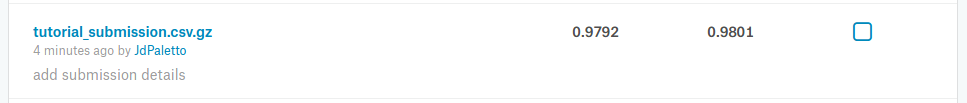

In [24]:
Image('tutorial_assets/sub.png', width=1000)

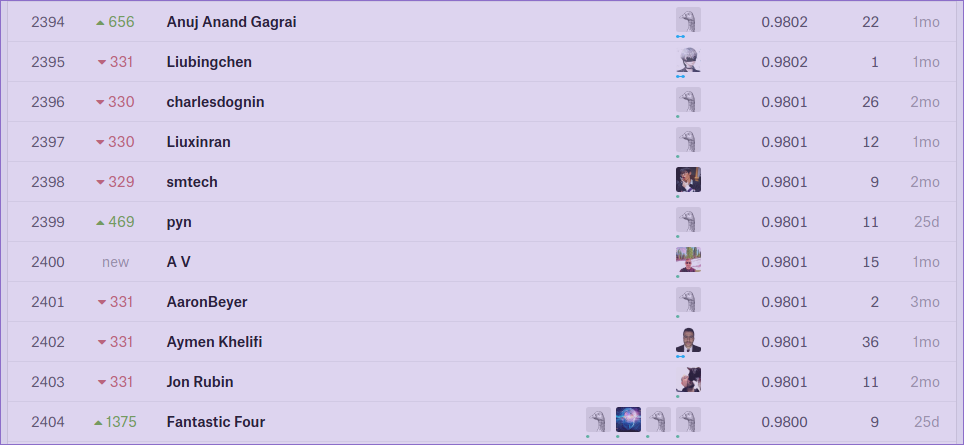

In [25]:
Image('tutorial_assets/LB.png', width=1000)

## CPU Comparison

The speed up at a mini batch size of 32 for 4 V100s to 32 CPU cores is about ~**8x**

In [ ]:
# build model
def get_model():
    with tf.device('/cpu:0'):
        inp = Input(shape=(maxlen, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen)(inp)
        x = Dropout(0.5)(x)    

        x = Bidirectional(LSTM(300, return_sequences=True), merge_mode='sum')(x)
        x = Dropout(0.2)(x)
        x = Reshape((200, 300, 1))(x)

        x = Conv2D(100, kernel_size=(5,5), padding='valid', kernel_initializer='glorot_uniform')(x)
        x = MaxPool2D(pool_size=(5,5))(x)

        x = Flatten()(x)
        x = Dropout(0.4)(x)
        x = Dense(6, activation = "sigmoid",  kernel_regularizer=regularizers.l2(.00001))(x)

        parallel_model = Model(inputs = inp, outputs = x)
    #     parallel_model = multi_gpu_model(parallel_model, gpus=4)
        parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return parallel_model



# get model
model = get_model()



# fit
hist = model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=1)

Epoch 1/1
  5120/159571 [..............................] - ETA: 1:22:25 - loss: 0.1977 - acc: 0.9524